In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix
import warnings
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')
import shutil
import seaborn as sns

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanishaj04","key":"a3cb43368a9900ff3cdeca529146250d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 769M/778M [00:12<00:00, 35.8MB/s]
100% 778M/778M [00:12<00:00, 65.3MB/s]


In [ ]:
!unzip '/content/covid19-radiography-database.zip'

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
PATH_TO_METADATA = "/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx"
df = pd.read_excel(PATH_TO_METADATA)
df.head()


,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
!ls /tmp

dap_multiplexer.7e035653d95f.root.log.INFO.20240708-214148.110	 pyright-833-qrMjROAzqPX9
dap_multiplexer.INFO						 pyright-833-x3mivMP8vAOJ
debugger_a2xbmpmh6						 python-languageserver-cancellation
initgoogle_syslog_dir.0						 tmp6nn_qiqf
language_service.7e035653d95f.root.log.INFO.20240708-214431.827  tmpmcn4n641
language_service.INFO


In [ ]:
!mkdir /tmp/Xray_train_data

In [ ]:
!cp -R "/content/COVID-19_Radiography_Dataset/COVID/images" "/tmp/Xray_train_data/"

In [ ]:
!mv "/tmp/Xray_train_data/images" "/tmp/Xray_train_data/COVID"

In [ ]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
 !mkdir "/tmp/Xray_train_data/NORMAL"

In [ ]:

cnt = 0
for (i, row) in df.iterrows():
    if (cnt < 3616):
        filename = row["FILE NAME"].lower().capitalize() + "." + row["FORMAT"].lower()
        image_path = os.path.join("/content/COVID-19_Radiography_Dataset/Normal/images", filename)
        image_copy_path = os.path.join("/tmp/Xray_train_data/NORMAL", filename)
        shutil.copy2(image_path, image_copy_path)
        cnt += 1

print(cnt)

3616


In [ ]:
!ls "/tmp/Xray_train_data"

COVID  NORMAL


In [ ]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l

3616


In [ ]:
train_data_dir= "/tmp/Xray_train_data"

In [ ]:
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width= IMAGE_SIZE
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 5064 images belonging to 2 classes.
Found 2168 images belonging to 2 classes.


In [ ]:
resnet50_model= Sequential()

pre_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg',
    classes=5,
    weights='imagenet'
)
for layer in pre_model.layers:
  layer.trainable= False

resnet50_model.add(pre_model)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(512, activation='relu'))
resnet50_model.add(Dense(1, activation='sigmoid'))


In [ ]:
resnet50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 4)

trainer=resnet50_model.fit(train_generator,validation_data=validation_generator,epochs=30, callbacks = [es])

Epoch 1/30
317/317 [==============================] - 37s 106ms/step - loss: 0.2735 - accuracy: 0.8839 - val_loss: 0.2060 - val_accuracy: 0.9211
Epoch 2/30
317/317 [==============================] - 32s 99ms/step - loss: 0.1621 - accuracy: 0.9412 - val_loss: 0.1636 - val_accuracy: 0.9387
Epoch 3/30
317/317 [==============================] - 32s 100ms/step - loss: 0.1229 - accuracy: 0.9585 - val_loss: 0.1309 - val_accuracy: 0.9511
Epoch 4/30
317/317 [==============================] - 32s 100ms/step - loss: 0.0935 - accuracy: 0.9708 - val_loss: 0.1252 - val_accuracy: 0.9525
Epoch 5/30
317/317 [==============================] - 33s 104ms/step - loss: 0.0800 - accuracy: 0.9751 - val_loss: 0.1224 - val_accuracy: 0.9525
Epoch 6/30
317/317 [==============================] - 32s 100ms/step - loss: 0.0666 - accuracy: 0.9805 - val_loss: 0.1104 - val_accuracy: 0.9553
Epoch 7/30
317/317 [==============================] - 32s 100ms/step - loss: 0.0535 - accuracy: 0.9850 - val_loss: 0.1146 - val_acc

Text(0.5, 1.0, 'Training-Validation Accuracy')

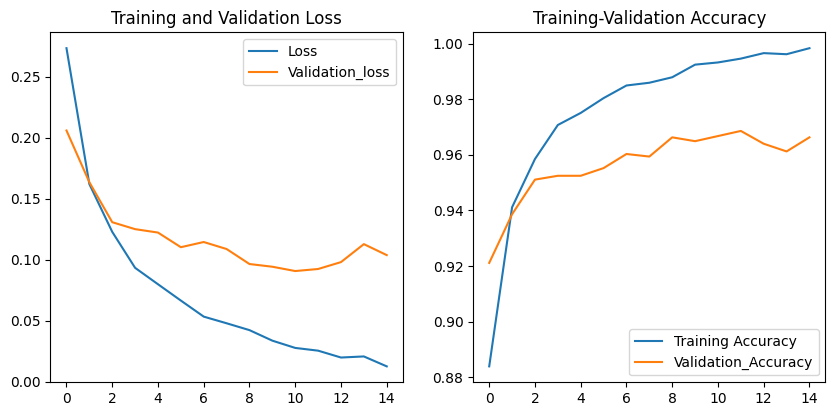

In [ ]:
loss=pd.DataFrame(resnet50_model.history.history)

#loss and accuracy
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(loss["loss"],label="Loss")
plt.plot(loss["val_loss"],label="Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label="Training Accuracy")
plt.plot(loss['val_accuracy'],label="Validation_Accuracy")
plt.legend()
plt.title("Training-Validation Accuracy")

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.49      0.50      1084
           1       0.50      0.52      0.51      1084

    accuracy                           0.50      2168
   macro avg       0.50      0.50      0.50      2168
weighted avg       0.50      0.50      0.50      2168



In [ ]:
probabilities = resnet50_model.predict_generator(generator=validation_generator)
probabilities


array([[5.6174998e-05],
       [1.5049521e-04],
       [9.8589408e-01],
       ...,
       [9.9997628e-01],
       [3.6304842e-05],
       [9.9435496e-01]], dtype=float32)

In [ ]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
y_pred

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [ ]:
class_report = classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()))
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       COVID       0.50      0.49      0.50      1084
      NORMAL       0.50      0.52      0.51      1084

    accuracy                           0.50      2168
   macro avg       0.50      0.50      0.50      2168
weighted avg       0.50      0.50      0.50      2168



Confusion Matrix:
        COVID  NORMAL
COVID     531     553
NORMAL    524     560


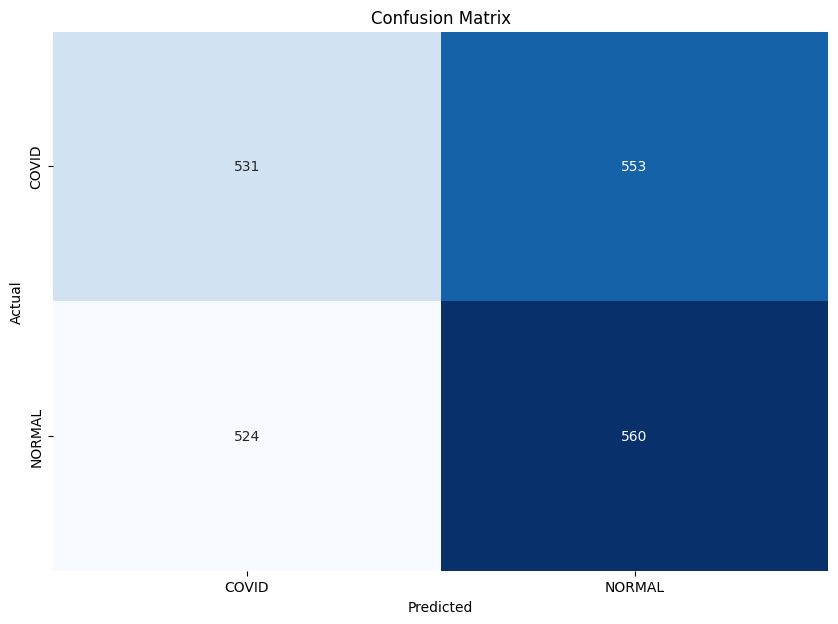

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())
cf_matrix_df = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cf_matrix_df)
plt.figure(figsize=(10, 7))
sns.heatmap(cf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()